# Analyze Representations in Path-Integrating RNN

Model from "Conformal Isometry of Lie Group Representation in Recurrent Network of Grid Cells" Xu, et al. 2022. (https://arxiv.org/abs/2210.02684)

### Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
#%load_ext jupyter_black

from neurometry.datasets.load_rnn_grid_cells import plot_rate_map
from neurometry.datasets.rnn_grid_cells.scores import GridScorer
import numpy as np
import skdim
import matplotlib.pyplot as plt

from neurometry.dimension.dimension import skdim_dimension_estimation
from neurometry.dimension.dimension import plot_dimension_experiments

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

from tqdm import tqdm


import pickle

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


INFO: Using pytorch backend


### Load trained model activations, loss

In [2]:
model_dir = os.getcwd() + "/curvature/grid-cells-curvature/models/grid-cell-rnn/"

run_dir = model_dir + "logs/rnn_isometry/20240416-055022"


event_file = run_dir + "/events.out.tfevents.1713271837.parka.3200199.0.v2"

step = 19500

weights_file = run_dir + "/weights/" + f"weights_{step}.pkl"

with open(weights_file, "rb") as f:
    weights = pickle.load(f)

Visualize rate maps

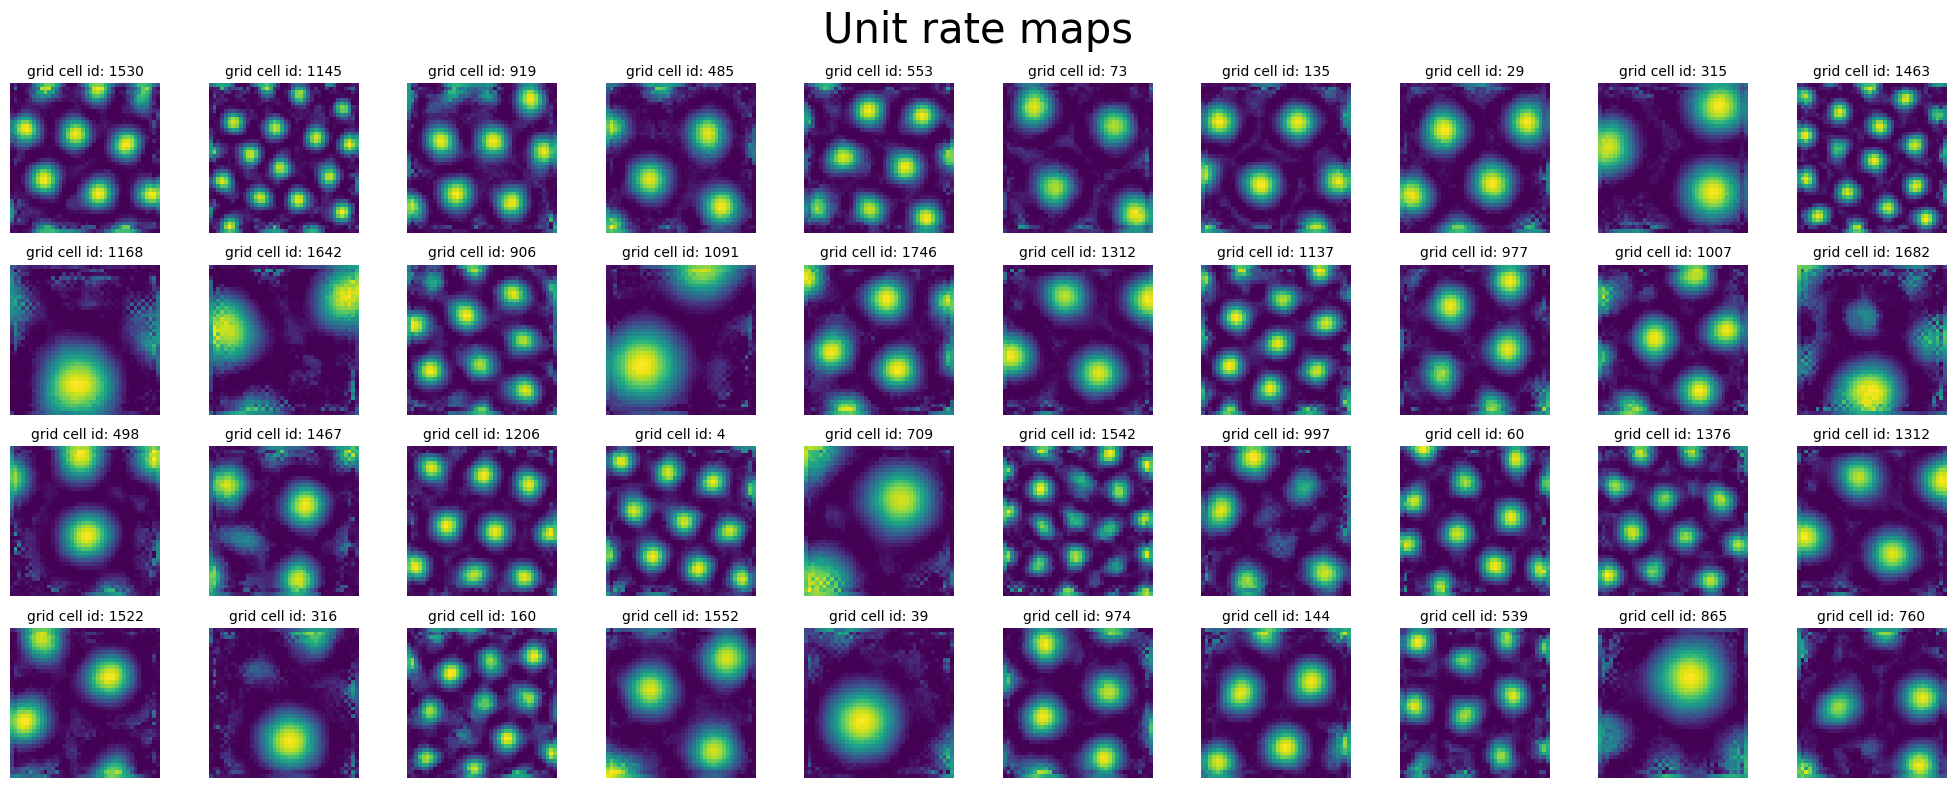

In [3]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map
plot_rate_map(None, 40, weights, "Unit rate maps")

In [4]:
import tensorflow as tf

def extract_tensor_events(event_file):
    records = []
    losses = []
    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            print(f"Found event at step {e.step} with wall time {e.wall_time}")
            for v in e.summary.value:
                print(f"Found value with tag: {v.tag}")
                if v.HasField("tensor"):
                    tensor = tf.make_ndarray(v.tensor)
                    record = {
                        "step": e.step,
                        "wall_time": e.wall_time,
                        "tag": v.tag,
                        "tensor": tensor,
                    }
                    records.append(record)
                    if v.tag == "loss":
                        loss = {"step": e.step, "loss": tensor}
                        losses.append(loss)
                else:
                    print(f"No 'tensor' found for tag {v.tag}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return records, losses


all_tensor_data, losses = extract_tensor_events(event_file)

2024-04-17 12:03:17.430180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 12:03:18.270491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Found event at step 0 with wall time 1713271837.0
Found event at step 1 with wall time 1713271844.512896
Found value with tag: loss_kernel
Found event at step 1 with wall time 1713271844.524665
Found value with tag: loss_trans
Found event at step 1 with wall time 1713271844.531902
Found value with tag: loss_isometry
Found event at step 1 with wall time 1713271844.539244
Found value with tag: loss_reg_u
Found event at step 1 with wall time 1713271844.540756
Found value with tag: loss
Found event at step 1 with wall time 1713271844.876654
Found value with tag: v
Found event at step 1 with wall time 1713271845.516311
Found value with tag: u
Found event at step 1 with wall time 1713271846.291745
Found value with tag: vu_heatmap
Found event at step 1 with wall time 1713271846.293621
Found value with tag: pred_x
Found event at step 1 with wall time 1713271846.294985
Found value with tag: error_fixed
Found event at step 1 with wall time 1713271846.296235
Found value with tag: error_fixed_zero

Visualize total loss through training

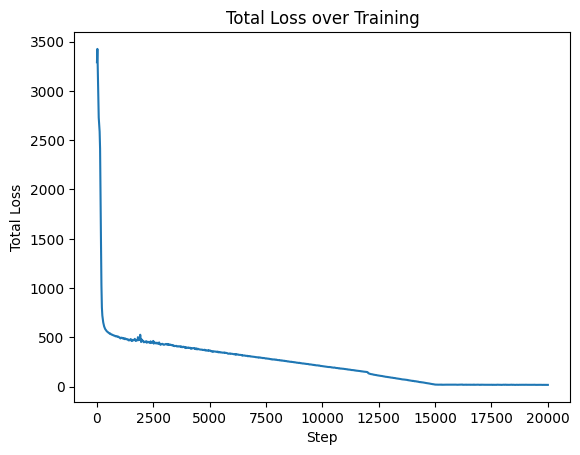

In [5]:
loss_vals = [l["loss"] for l in losses]
loss_steps = [l["step"] for l in losses]

plt.plot(loss_steps, loss_vals)
plt.xlabel("Step")
plt.ylabel("Total Loss")
plt.title("Total Loss over Training");

### Compute grid scores

In [7]:
block_size = 12
num_neurons = 1800
num_block = num_neurons // block_size

starts = [0.1] * 20
ends = np.linspace(0.2, 1.4, num=20)

masks_parameters = zip(starts, ends.tolist())

ncol, nrow = block_size, num_block

scorer = GridScorer(40, ((0, 1), (0, 1)), masks_parameters)

score_list = np.zeros(shape=[len(weights)], dtype=np.float32)
scale_list = np.zeros(shape=[len(weights)], dtype=np.float32)
#orientation_list = np.zeros(shape=[len(weights)], dtype=np.float32)
sac_list = []

for i in range(len(weights)):
    rate_map = weights[i]
    rate_map = (rate_map - rate_map.min()) / (rate_map.max() - rate_map.min())

    score_60, score_90, max_60_mask, max_90_mask, sac, _ = scorer.get_scores(
        weights[i])
    sac_list.append(sac)

    score_list[i] = score_60
    # scale_list[i] = scale
    scale_list[i] = max_60_mask[1]
    # orientation_list[i] = orientation


scale_tensor = torch.from_numpy(scale_list)
score_tensor = torch.from_numpy(score_list)
max_scale = torch.max(scale_tensor[score_list > 0.37])

scale_tensor = scale_tensor.reshape((num_block, block_size))
scale_tensor = torch.mean(scale_tensor, dim=1)

# score_tensor = score_tensor.reshape((num_block, block_size))
score_tensor = torch.mean(score_tensor)
sac_array = np.array(sac_list)

In [ ]:
score_list = np.zeros(shape=[len(weights)], dtype=np.float32)
scale_list = np.zeros(shape=[len(weights)], dtype=np.float32)
#orientation_list = np.zeros(shape=[len(weights)], dtype=np.float32)
sac_list = []


for i in range(len(weights_1)):
    rate_map = weights_1[i]
    rate_map = (rate_map - rate_map.min()) / (rate_map.max() - rate_map.min())

    score_60, score_90, max_60_mask, max_90_mask, sac, _ = scorer.get_scores(
        weights_1[i])
    sac_list.append(sac)

    score_list[i] = score_60
    # scale_list[i] = scale
    scale_list[i] = max_60_mask[1]
    # orientation_list[i] = orientation


scale_tensor = torch.from_numpy(scale_list)
score_tensor = torch.from_numpy(score_list)
max_scale = torch.max(scale_tensor[score_list > 0.37])

scale_tensor = scale_tensor.reshape((num_block, block_size))
scale_tensor = torch.mean(scale_tensor, dim=1)

# score_tensor = score_tensor.reshape((num_block, block_size))
score_tensor = torch.mean(score_tensor)
sac_array = np.array(sac_list)

In [14]:
scale_tensor = torch.from_numpy(scale_list)
score_tensor = torch.from_numpy(score_list)
max_scale = torch.max(scale_tensor[score_list > 0.37])

scale_tensor = scale_tensor.reshape((num_block, block_size))
scale_tensor = torch.mean(scale_tensor, dim=1)

(array([ 4., 11.,  3.,  8., 12., 19., 13., 10., 13., 12.,  6.,  7., 11.,
         4.,  8.,  1.,  4.,  3.,  0.,  1.]),
 array([0.26315787, 0.30078945, 0.33842102, 0.37605259, 0.41368419,
        0.45131576, 0.48894733, 0.5265789 , 0.56421047, 0.60184205,
        0.63947362, 0.67710519, 0.71473676, 0.75236833, 0.78999996,
        0.82763153, 0.8652631 , 0.90289468, 0.94052625, 0.97815782,
        1.01578939]),
 <BarContainer object of 20 artists>)

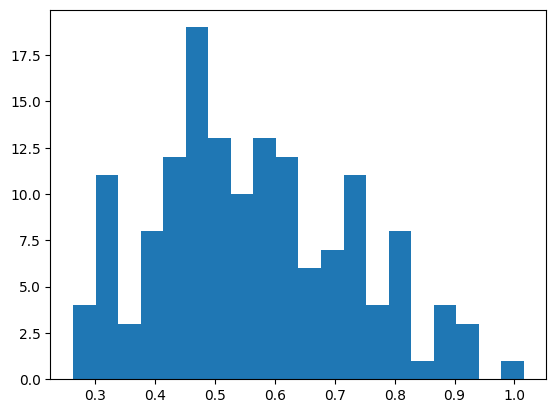

In [17]:
plt.hist(scale_tensor, bins=20);

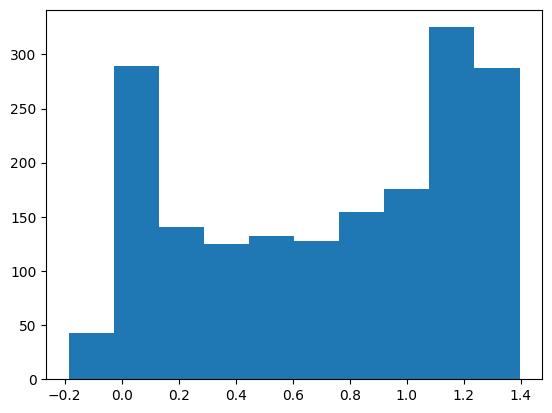

In [22]:
plt.hist(score_tensor);

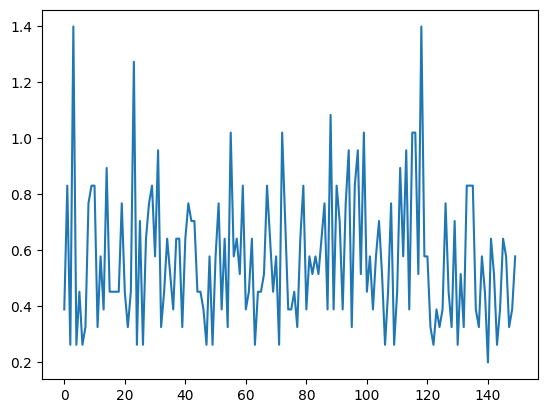

### Define subpolations based on UMAP on spatial autocorrelation scores

In [6]:
# turn sac list into numpy array
sac_array.shape

def z_standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)


def vectorized_spatial_autocorrelation_matrix(spatial_autocorrelation):
    num_cells = spatial_autocorrelation.shape[0]
    num_bins = spatial_autocorrelation.shape[1] * spatial_autocorrelation.shape[2]

    spatial_autocorrelation_matrix = np.zeros((num_bins, num_cells))

    for i in range(num_cells):
        vector = spatial_autocorrelation[i].flatten()

        spatial_autocorrelation_matrix[:, i] = vector

    return z_standardize(spatial_autocorrelation_matrix)


spatial_autocorrelation_matrix = vectorized_spatial_autocorrelation_matrix(
    sac_array
)

print(spatial_autocorrelation_matrix.shape)

NameError: name 'sac_array' is not defined

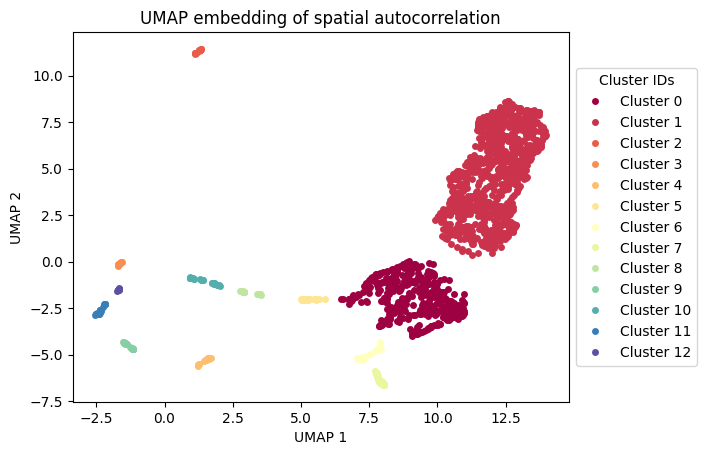

In [101]:
from sklearn.cluster import DBSCAN
import umap
umap_reducer_2d = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer_2d.fit_transform(spatial_autocorrelation_matrix.T)

# Clustering with DBSCAN
umap_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(umap_embedding)

# Plot each cluster
unique_labels = np.unique(umap_dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (umap_dbscan.labels_ == k)

    xy = umap_embedding[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='none', markersize=5, label=f'Cluster {k}')  # Removed black edge

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP embedding of spatial autocorrelation")
plt.legend(title="Cluster IDs", loc='center left', bbox_to_anchor=(1, 0.5))  # Moved legend to the right
plt.show()

In [99]:
umap_clusters = umap_dbscan.fit_predict(umap_embedding)

def get_data_from_cluster(data,cluster_id):
    return data[umap_clusters == cluster_id]

clusters = []

for i in np.unique(umap_clusters):
    cluster = get_data_from_cluster(weights,i)
    clusters.append(cluster)

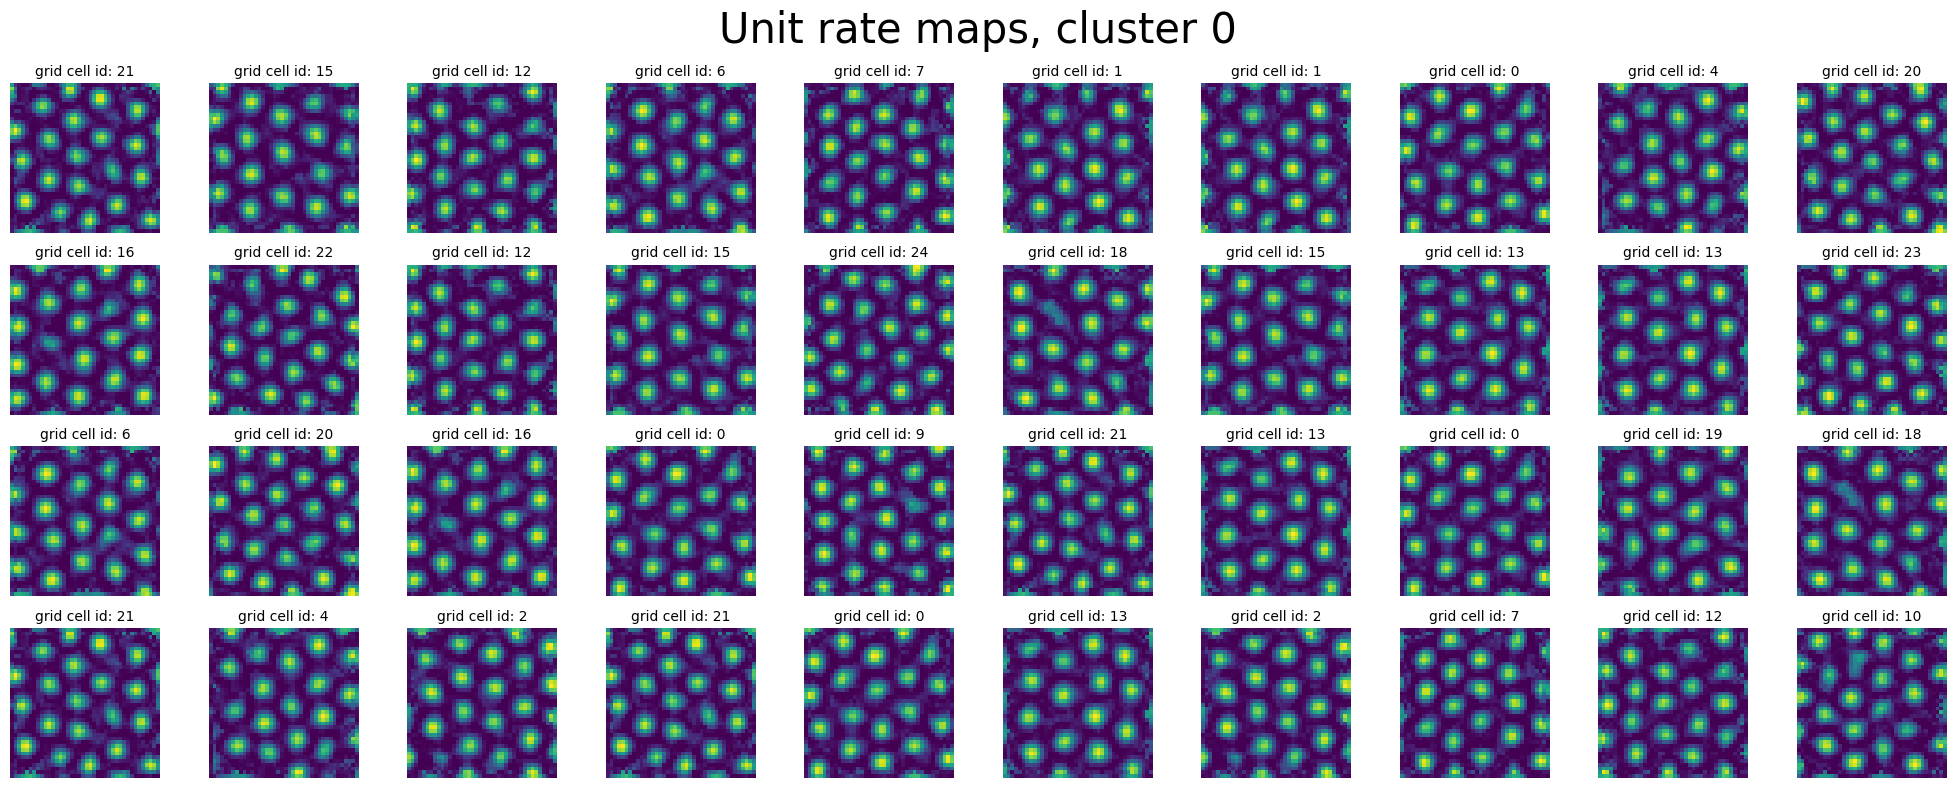

In [100]:
plot_rate_map(None, 40, clusters[11], "Unit rate maps, cluster 0")

In [107]:
neural_points = clusters[11].reshape(len(clusters[11]),-1).T
print(neural_points.shape)

(1600, 26)


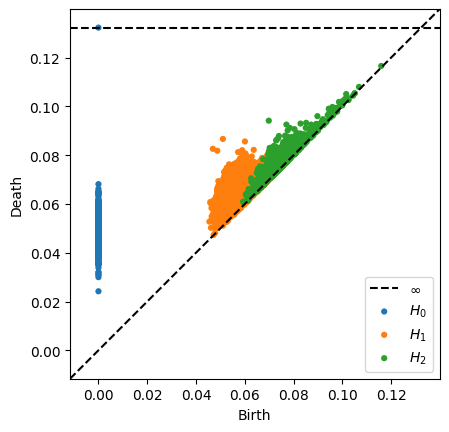

In [109]:
from ripser import ripser
from persim import plot_diagrams

diagrams = ripser(neural_points, maxdim=2)["dgms"]

# turn off latex rendering
plt.rc('text', usetex=False)
plot_diagrams(diagrams)